In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces, logger
from gym.utils import seeding
from scipy.integrate import odeint
from tqdm import tqdm
import os
import torch.nn as nn
import torch as T
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal

In [2]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions,
            name, chkpt_dir='tmp/td3'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        # I think this breaks if the env has a 2D state representation
        self.fc1 = nn.Linear(self.input_dims[0] + n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.q1 = nn.Linear(self.fc2_dims, 1)
        
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q1.weight.data.uniform_(-f3, f3)
        self.q1.bias.data.uniform_(-f3, f3)
        
        self.optimizer = optim.Adam(self.parameters(), lr=beta, weight_decay=0.01)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        q1_action_value = self.fc1(T.cat([state, action], dim=1))
        q1_action_value = self.bn1(q1_action_value)
        q1_action_value = F.relu(q1_action_value)
        q1_action_value = self.fc2(q1_action_value)
        q1_action_value = self.bn2(q1_action_value)
        q1_action_value = F.relu(q1_action_value)

        q1 = self.q1(q1_action_value)

        return q1

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [3]:
class Agent():
    def __init__(self, alpha, beta, input_dims, tau, env, setpoint,
            gamma=0.99, update_actor_interval=2, warmup=0,
            n_actions=2, max_size=1000000, layer1_size=400,
            layer2_size=300, batch_size=128):
        
        self.noise = OUActionNoise(mu=np.zeros(n_actions))
        self.gamma = gamma
        self.tau = tau
        self.setpoint = setpoint
        self.max_action = env.action_space.high
        self.min_action = env.action_space.low
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.n_actions = n_actions
        self.update_actor_iter = update_actor_interval

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='actor')
        self.critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                                      layer2_size, n_actions=n_actions,
                                      name='critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                                      layer2_size, n_actions=n_actions,
                                      name='critic_2')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='target_actor')
        self.target_critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='target_critic_1')
        self.target_critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='target_critic_2')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        
        if self.time_step < self.warmup:
            mu = T.tensor(np.random.normal(scale=0.1, size=(self.n_actions,))).to(self.actor.device)
        else:
            state = T.tensor(observation, dtype=T.float).to(self.actor.device)
            mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(np.random.normal(scale=0.1),
                dtype=T.float).to(self.actor.device)
        # mu_prime = T.clamp(mu_prime, self.min_action[0], self.max_action[0])
        self.time_step += 1    # \\
        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic_1.device)
        done = T.tensor(done).to(self.critic_1.device)
        state_ = T.tensor(new_state, dtype=T.float).to(self.critic_1.device)
        state = T.tensor(state, dtype=T.float).to(self.critic_1.device)
        action = T.tensor(action, dtype=T.float).to(self.critic_1.device)

        target_actions = self.target_actor.forward(state_)
        target_actions = target_actions + \
                T.clamp(T.tensor(np.random.normal(scale=0.2)), -0.5, 0.5)
        # might break if elements of min and max are not all equal
        target_actions = T.clamp(target_actions, self.min_action[0], self.max_action[0])

        q1_ = self.target_critic_1.forward(state_, target_actions)
        q2_ = self.target_critic_2.forward(state_, target_actions)

        q1 = self.critic_1.forward(state, action)
        q2 = self.critic_2.forward(state, action)

        q1_[done] = 0.0
        q2_[done] = 0.0

        q1_ = q1_.view(-1)
        q2_ = q2_.view(-1)

        critic_value_ = T.min(q1_, q2_)

        target = reward + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()

        q1_loss = F.mse_loss(target, q1)
        q2_loss = F.mse_loss(target, q2)
        critic_loss = q1_loss + q2_loss
        critic_loss.backward()

        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.learn_step_cntr += 1

        # if self.learn_step_cntr % self.update_actor_iter != 0:
        #    return

        self.actor.optimizer.zero_grad()
        actor_q1_loss = -self.critic_1.forward(state, self.actor.forward(state))
        actor_loss = T.mean(actor_q1_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_1_params = self.critic_1.named_parameters()
        critic_2_params = self.critic_2.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_1_params = self.target_critic_1.named_parameters()
        target_critic_2_params = self.target_critic_2.named_parameters()

        critic_1_state_dict = dict(critic_1_params)
        critic_2_state_dict = dict(critic_2_params)
        actor_state_dict = dict(actor_params)
        target_actor_state_dict = dict(target_actor_params)
        target_critic_1_state_dict = dict(target_critic_1_params)
        target_critic_2_state_dict = dict(target_critic_2_params)

        for name in critic_1_state_dict:
            critic_1_state_dict[name] = tau*critic_1_state_dict[name].clone() + \
                    (1-tau)*target_critic_1_state_dict[name].clone()

        for name in critic_2_state_dict:
            critic_2_state_dict[name] = tau*critic_2_state_dict[name].clone() + \
                    (1-tau)*target_critic_2_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                    (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic_1.load_state_dict(critic_1_state_dict)
        self.target_critic_2.load_state_dict(critic_2_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()
        self.target_critic_1.load_checkpoint()
        self.target_critic_2.load_checkpoint()

In [4]:
class Process(gym.Env):
    def __init__(self, n_yt, n_ut, n_rew, setpoint):
      self.Kp = 3.0
      self.taup = 5.0
      self.delta_t = 0.1
      self.steps = 0
      self.count = 0
      self.n_yt = n_yt
      self.n_ut = n_ut
      self.n_rew = n_rew
      self.eps = 1e-5
     
      dim = self.n_yt+self.n_ut+self.n_rew
      self.dim = dim
      self.setpoint = np.array(setpoint)
      self.state = np.array([0]*dim, dtype=np.float32)

      state_high = np.array([100.0]*dim, dtype=np.float)
      state_low = np.array([0.0]*dim, dtype=np.float)
      action_high = np.array([100.0], dtype=np.float)
      action_low = np.array([0.0], dtype=np.float)

      self.observation_space = spaces.Box(state_low, state_high, dtype=np.float32)
      self.action_space = spaces.Box(action_low, action_high, dtype=np.float32)


    def process(self,y,t,action):
      # Kp = process gain
      # taup = process time constant
        dydt = -y/self.taup + self.Kp*action/self.taup
        return dydt

    def step(self, act):
      st_2, st_1, st_0, _ = self.state[0], self.state[1:self.n_yt-1], self.state[self.n_yt-1], self.state[self.n_yt:]
#      st__1 = odeint(self.process,st_0,[0,self.delta_t],args=(act[-1],))[-1][0]
      st__1 = self.Kp*(1-np.exp(-self.steps/self.taup))*act[-1]
      self.steps += 1
      reward = -np.abs(st__1-self.setpoint[self.steps-1])
      
      st_1 = np.append(st_1, [st_0, st__1])
      st_1 = np.append(st_1, [act])
      self.state = np.append(st_1, [reward])
      done = bool(self.steps>=300)

      return (self.state, reward, done, {})

    def reset(self):
      self.state = [0]*self.dim
      self.steps = 0
      self.count = 0
      return np.array(self.state)

In [5]:
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  1%|          | 1/100 [00:04<07:12,  4.37s/it]

episode: 0 score: -110.28 average score: -110.28


 11%|█         | 11/100 [00:47<06:31,  4.40s/it]

episode: 10 score: -76.01 average score: -75.95


 21%|██        | 21/100 [01:30<05:41,  4.32s/it]

episode: 20 score: -74.67 average score: -74.19


 31%|███       | 31/100 [02:13<04:55,  4.29s/it]

episode: 30 score: -77.08 average score: -74.72


 41%|████      | 41/100 [02:56<04:16,  4.34s/it]

episode: 40 score: -72.79 average score: -73.35


 51%|█████     | 51/100 [03:39<03:30,  4.30s/it]

episode: 50 score: -73.74 average score: -73.91


 61%|██████    | 61/100 [04:23<02:47,  4.29s/it]

episode: 60 score: -75.18 average score: -73.91


 71%|███████   | 71/100 [05:06<02:06,  4.35s/it]

episode: 70 score: -69.77 average score: -75.5


 81%|████████  | 81/100 [05:49<01:21,  4.31s/it]

episode: 80 score: -73.16 average score: -74.92


 91%|█████████ | 91/100 [06:33<00:38,  4.33s/it]

episode: 90 score: -76.0 average score: -73.39


100%|██████████| 100/100 [07:13<00:00,  4.33s/it]


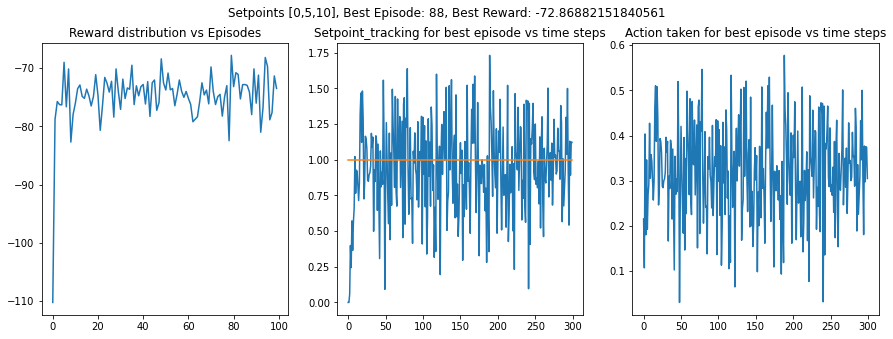

  1%|          | 1/100 [00:03<06:11,  3.75s/it]

episode: 0 score: -278.4 average score: -278.4


 11%|█         | 11/100 [00:46<06:18,  4.25s/it]

episode: 10 score: -97.49 average score: -94.17


 21%|██        | 21/100 [01:30<05:48,  4.41s/it]

episode: 20 score: -95.58 average score: -94.78


 31%|███       | 31/100 [02:14<04:59,  4.35s/it]

episode: 30 score: -97.41 average score: -95.19


 41%|████      | 41/100 [02:57<04:11,  4.26s/it]

episode: 40 score: -97.75 average score: -95.81


 51%|█████     | 51/100 [03:40<03:33,  4.36s/it]

episode: 50 score: -95.75 average score: -97.34


 61%|██████    | 61/100 [04:23<02:47,  4.30s/it]

episode: 60 score: -92.23 average score: -93.72


 71%|███████   | 71/100 [05:07<02:03,  4.27s/it]

episode: 70 score: -101.05 average score: -95.0


 81%|████████  | 81/100 [05:50<01:23,  4.40s/it]

episode: 80 score: -94.52 average score: -94.86


 91%|█████████ | 91/100 [06:34<00:39,  4.35s/it]

episode: 90 score: -99.59 average score: -94.48


100%|██████████| 100/100 [07:13<00:00,  4.34s/it]


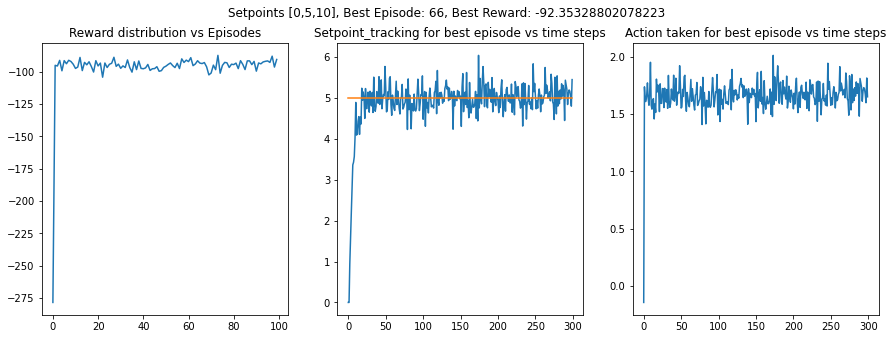

  1%|          | 1/100 [00:04<06:57,  4.22s/it]

episode: 0 score: -483.06 average score: -483.06


 11%|█         | 11/100 [00:48<06:30,  4.39s/it]

episode: 10 score: -117.28 average score: -121.83


 21%|██        | 21/100 [01:32<05:48,  4.42s/it]

episode: 20 score: -122.49 average score: -122.48


 31%|███       | 31/100 [02:15<05:03,  4.41s/it]

episode: 30 score: -124.96 average score: -121.93


 41%|████      | 41/100 [02:59<04:16,  4.35s/it]

episode: 40 score: -117.9 average score: -122.87


 51%|█████     | 51/100 [03:42<03:31,  4.32s/it]

episode: 50 score: -121.82 average score: -121.84


 61%|██████    | 61/100 [04:26<02:52,  4.41s/it]

episode: 60 score: -124.71 average score: -122.1


 71%|███████   | 71/100 [05:10<02:06,  4.36s/it]

episode: 70 score: -122.59 average score: -120.89


 81%|████████  | 81/100 [05:53<01:23,  4.38s/it]

episode: 80 score: -120.26 average score: -122.34


 91%|█████████ | 91/100 [06:37<00:39,  4.36s/it]

episode: 90 score: -119.32 average score: -119.84


100%|██████████| 100/100 [07:16<00:00,  4.36s/it]


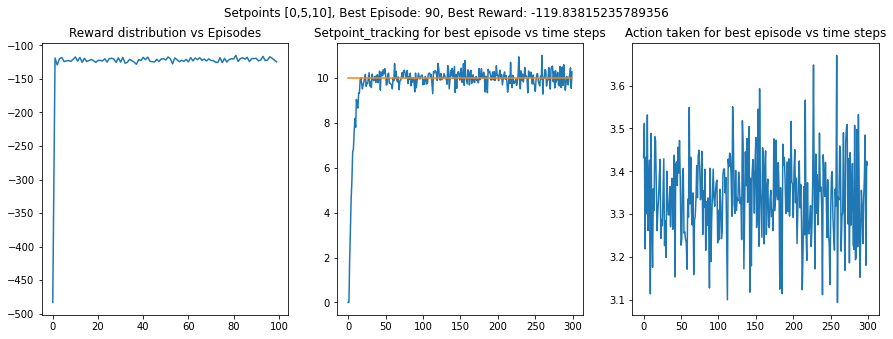

  1%|          | 1/100 [00:04<06:36,  4.01s/it]

episode: 0 score: -28288.7 average score: -28288.7


 11%|█         | 11/100 [00:47<06:35,  4.44s/it]

episode: 10 score: -342.74 average score: -583.57


 21%|██        | 21/100 [01:30<05:40,  4.31s/it]

episode: 20 score: -336.44 average score: -339.12


 31%|███       | 31/100 [02:14<04:56,  4.30s/it]

episode: 30 score: -337.1 average score: -339.94


 41%|████      | 41/100 [02:57<04:17,  4.36s/it]

episode: 40 score: -337.62 average score: -341.69


 51%|█████     | 51/100 [03:41<03:35,  4.41s/it]

episode: 50 score: -341.14 average score: -341.88


 61%|██████    | 61/100 [04:25<02:47,  4.29s/it]

episode: 60 score: -336.39 average score: -340.65


 71%|███████   | 71/100 [05:08<02:06,  4.37s/it]

episode: 70 score: -337.58 average score: -340.64


 81%|████████  | 81/100 [05:52<01:22,  4.35s/it]

episode: 80 score: -336.51 average score: -339.51


 91%|█████████ | 91/100 [06:35<00:38,  4.33s/it]

episode: 90 score: -340.55 average score: -340.92


100%|██████████| 100/100 [07:15<00:00,  4.36s/it]


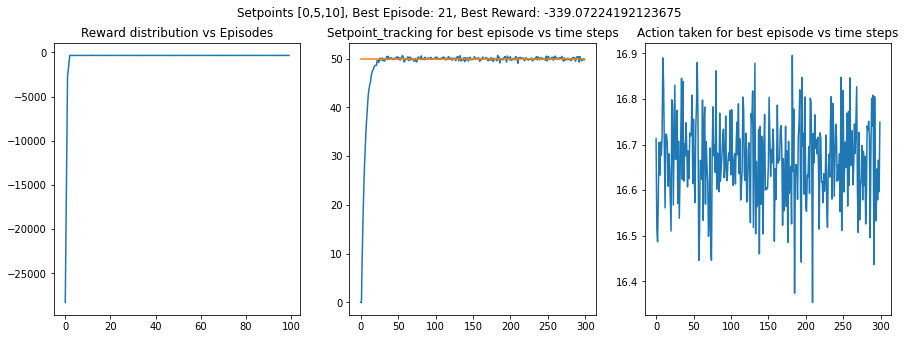

  1%|          | 1/100 [00:03<06:29,  3.94s/it]

episode: 0 score: -49623.9 average score: -49623.9


 11%|█         | 11/100 [00:47<06:25,  4.33s/it]

episode: 10 score: -610.89 average score: -617.05


 21%|██        | 21/100 [01:31<05:43,  4.34s/it]

episode: 20 score: -615.56 average score: -615.86


 31%|███       | 31/100 [02:14<05:00,  4.35s/it]

episode: 30 score: -809.45 average score: -633.55


 41%|████      | 41/100 [02:58<04:15,  4.33s/it]

episode: 40 score: -617.84 average score: -615.71


 51%|█████     | 51/100 [03:42<03:35,  4.40s/it]

episode: 50 score: -614.57 average score: -614.15


 61%|██████    | 61/100 [04:26<02:54,  4.47s/it]

episode: 60 score: -611.49 average score: -615.23


 71%|███████   | 71/100 [05:09<02:05,  4.32s/it]

episode: 70 score: -615.42 average score: -613.52


 81%|████████  | 81/100 [05:52<01:21,  4.31s/it]

episode: 80 score: -618.18 average score: -613.84


 91%|█████████ | 91/100 [06:36<00:39,  4.37s/it]

episode: 90 score: -618.11 average score: -617.14


100%|██████████| 100/100 [07:16<00:00,  4.36s/it]


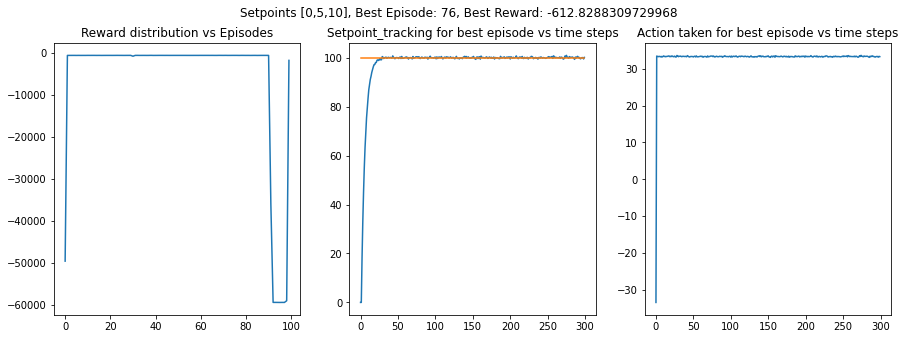

  1%|          | 1/100 [00:03<06:13,  3.77s/it]

episode: 0 score: -139.6 average score: -139.6


 11%|█         | 11/100 [00:48<06:43,  4.53s/it]

episode: 10 score: -69.78 average score: -88.44


 21%|██        | 21/100 [01:31<05:45,  4.38s/it]

episode: 20 score: -70.83 average score: -73.57


 31%|███       | 31/100 [02:15<05:03,  4.40s/it]

episode: 30 score: -69.29 average score: -74.56


 41%|████      | 41/100 [03:00<04:25,  4.50s/it]

episode: 40 score: -65.28 average score: -70.09


 51%|█████     | 51/100 [03:44<03:34,  4.39s/it]

episode: 50 score: -71.24 average score: -73.19


 61%|██████    | 61/100 [04:27<02:49,  4.35s/it]

episode: 60 score: -71.82 average score: -73.52


 71%|███████   | 71/100 [05:11<02:06,  4.38s/it]

episode: 70 score: -71.27 average score: -72.02


 81%|████████  | 81/100 [05:55<01:23,  4.39s/it]

episode: 80 score: -70.42 average score: -73.11


 91%|█████████ | 91/100 [06:39<00:39,  4.44s/it]

episode: 90 score: -71.97 average score: -73.87


100%|██████████| 100/100 [07:18<00:00,  4.38s/it]


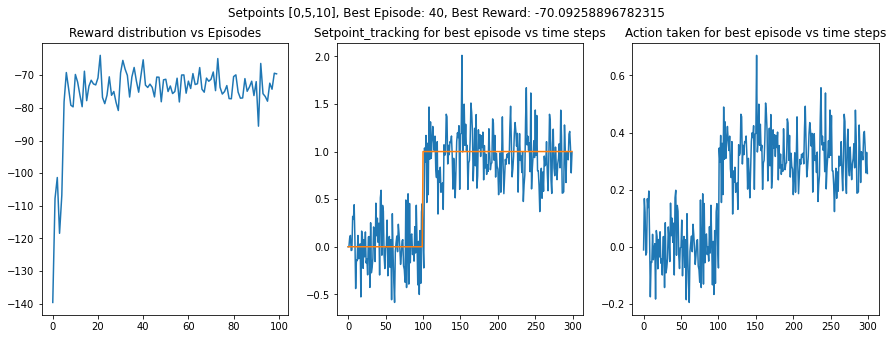

  1%|          | 1/100 [00:03<06:33,  3.98s/it]

episode: 0 score: -469.53 average score: -469.53


 11%|█         | 11/100 [00:47<06:26,  4.35s/it]

episode: 10 score: -79.82 average score: -78.12


 21%|██        | 21/100 [01:31<05:53,  4.47s/it]

episode: 20 score: -73.39 average score: -73.0


 31%|███       | 31/100 [02:15<05:06,  4.45s/it]

episode: 30 score: -73.1 average score: -74.41


 41%|████      | 41/100 [02:59<04:16,  4.35s/it]

episode: 40 score: -80.28 average score: -76.75


 51%|█████     | 51/100 [03:44<03:41,  4.52s/it]

episode: 50 score: -72.36 average score: -74.9


 61%|██████    | 61/100 [04:28<02:52,  4.43s/it]

episode: 60 score: -74.57 average score: -73.55


 71%|███████   | 71/100 [05:12<02:08,  4.41s/it]

episode: 70 score: -71.95 average score: -75.55


 81%|████████  | 81/100 [05:57<01:23,  4.41s/it]

episode: 80 score: -78.05 average score: -76.3


 91%|█████████ | 91/100 [06:41<00:39,  4.36s/it]

episode: 90 score: -78.25 average score: -75.0


100%|██████████| 100/100 [07:20<00:00,  4.41s/it]


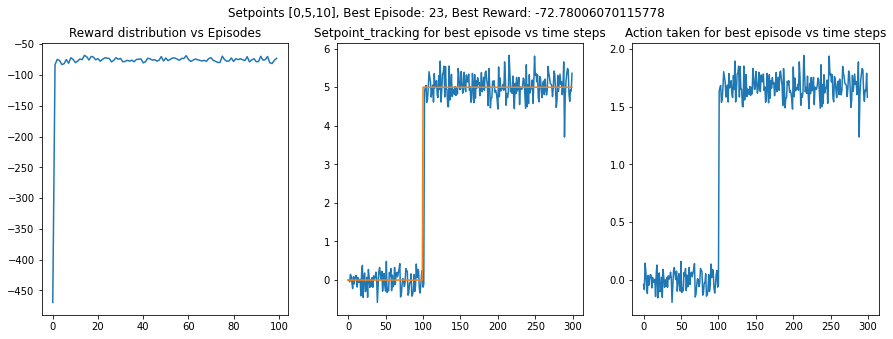

  1%|          | 1/100 [00:04<06:57,  4.21s/it]

episode: 0 score: -737.45 average score: -737.45


 11%|█         | 11/100 [00:48<06:30,  4.39s/it]

episode: 10 score: -81.0 average score: -124.43


 21%|██        | 21/100 [01:32<05:44,  4.36s/it]

episode: 20 score: -100.21 average score: -278.26


 31%|███       | 31/100 [02:16<05:06,  4.44s/it]

episode: 30 score: -82.91 average score: -90.17


 41%|████      | 41/100 [03:00<04:18,  4.39s/it]

episode: 40 score: -85.63 average score: -84.89


 51%|█████     | 51/100 [03:44<03:32,  4.35s/it]

episode: 50 score: -827.21 average score: -157.57


 61%|██████    | 61/100 [04:28<02:50,  4.37s/it]

episode: 60 score: -82.77 average score: -145.58


 71%|███████   | 71/100 [05:12<02:07,  4.39s/it]

episode: 70 score: -85.09 average score: -81.77


 81%|████████  | 81/100 [05:56<01:24,  4.47s/it]

episode: 80 score: -81.39 average score: -331.26


 91%|█████████ | 91/100 [06:40<00:39,  4.42s/it]

episode: 90 score: -89.23 average score: -81.1


100%|██████████| 100/100 [07:20<00:00,  4.41s/it]


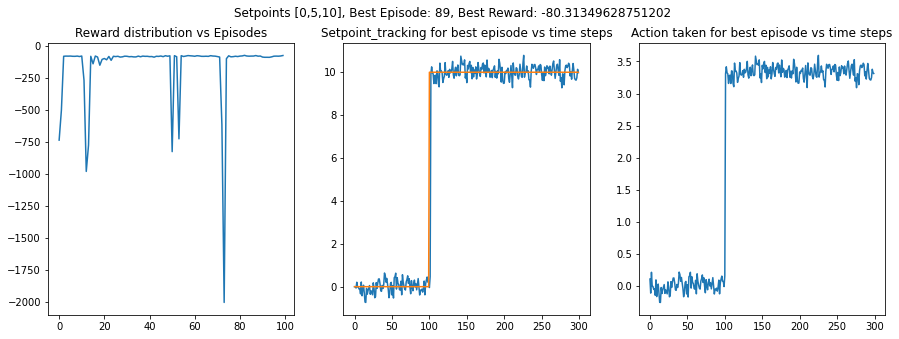

  1%|          | 1/100 [00:03<06:15,  3.79s/it]

episode: 0 score: -2053.12 average score: -2053.12


 11%|█         | 11/100 [00:48<06:33,  4.42s/it]

episode: 10 score: -155.4 average score: -1840.91


 21%|██        | 21/100 [01:32<05:46,  4.38s/it]

episode: 20 score: -170.88 average score: -169.74


 31%|███       | 31/100 [02:16<05:11,  4.52s/it]

episode: 30 score: -129.66 average score: -136.47


 41%|████      | 41/100 [03:00<04:18,  4.39s/it]

episode: 40 score: -119.55 average score: -126.93


 51%|█████     | 51/100 [03:44<03:33,  4.36s/it]

episode: 50 score: -122.29 average score: -124.1


 61%|██████    | 61/100 [04:28<02:56,  4.53s/it]

episode: 60 score: -126.56 average score: -120.72


 71%|███████   | 71/100 [05:12<02:06,  4.35s/it]

episode: 70 score: -120.71 average score: -122.62


 81%|████████  | 81/100 [05:56<01:24,  4.47s/it]

episode: 80 score: -120.91 average score: -123.24


 91%|█████████ | 91/100 [06:40<00:39,  4.43s/it]

episode: 90 score: -120.38 average score: -121.06


100%|██████████| 100/100 [07:19<00:00,  4.40s/it]


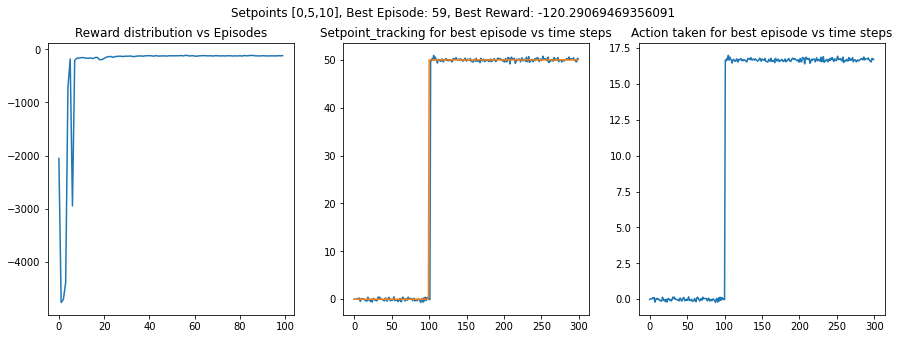

  1%|          | 1/100 [00:03<06:16,  3.80s/it]

episode: 0 score: -19132.21 average score: -19132.21


 11%|█         | 11/100 [00:48<06:41,  4.51s/it]

episode: 10 score: -325.12 average score: -3130.49


 21%|██        | 21/100 [01:32<05:46,  4.39s/it]

episode: 20 score: -240.9 average score: -303.27


 31%|███       | 31/100 [02:16<04:59,  4.34s/it]

episode: 30 score: -175.66 average score: -178.74


 41%|████      | 41/100 [03:00<04:21,  4.43s/it]

episode: 40 score: -177.11 average score: -176.33


 51%|█████     | 51/100 [03:45<03:37,  4.44s/it]

episode: 50 score: -171.62 average score: -173.48


 61%|██████    | 61/100 [04:31<03:00,  4.62s/it]

episode: 60 score: -171.41 average score: -199.82


 71%|███████   | 71/100 [05:16<02:09,  4.48s/it]

episode: 70 score: -170.21 average score: -172.57


 81%|████████  | 81/100 [06:00<01:23,  4.39s/it]

episode: 80 score: -176.32 average score: -174.71


 91%|█████████ | 91/100 [06:45<00:41,  4.58s/it]

episode: 90 score: -169.36 average score: -170.98


100%|██████████| 100/100 [07:25<00:00,  4.46s/it]


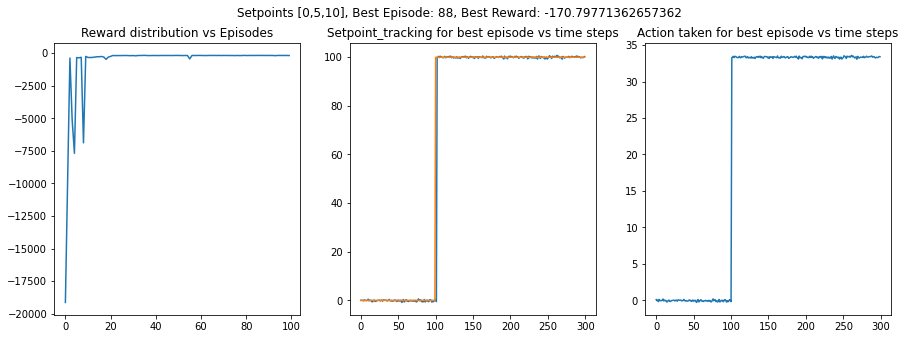

In [6]:
setpoints = [[1]*300, [5]*300, [10]*300, [50]*300, [100]*300, [0]*100+[1]*200, [0]*100+[5]*200, [0]*100+[10]*200, [0]*100+[50]*200, [0]*100+[100]*200]

for digit,setpoint in enumerate(setpoints):

    n_yt = 2
    n_ut = 1
    n_prev_reward = 1
    env = Process(n_yt,n_ut,n_prev_reward, setpoint)
    n_games = 100
    fc1_dims = 400
    fc2_dims = 300

    class ActorNetwork(nn.Module):
        def __init__(self, alpha, input_dims, fc1_dims, fc2_dims,
                n_actions, name, chkpt_dir='tmp/td3'):
            super(ActorNetwork, self).__init__()
            self.input_dims = input_dims
            self.fc1_dims = fc1_dims
            self.fc2_dims = fc2_dims
            self.n_actions = n_actions
            self.name = name
            self.checkpoint_dir = chkpt_dir
            self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
            self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

            self.bn1 = nn.LayerNorm(self.fc1_dims)
            self.bn2 = nn.LayerNorm(self.fc2_dims)

            self.mu = nn.Linear(self.fc2_dims, self.n_actions)

            f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
            self.fc2.weight.data.uniform_(-f2, f2)
            self.fc2.bias.data.uniform_(-f2, f2)

            f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
            self.fc1.weight.data.uniform_(-f1, f1)
            self.fc1.bias.data.uniform_(-f1, f1)

            f3 = 0.003
            self.mu.weight.data.uniform_(-f3, f3)
            self.mu.bias.data.uniform_(-f3, f3)

            self.optimizer = optim.Adam(self.parameters(), lr=alpha)
            self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

            self.to(self.device)

        def forward(self, state):
            prob = self.fc1(state)
            # prob = self.bn1(prob)
            prob = F.relu(prob)
            prob = self.fc2(prob)
            # prob = self.bn2(prob)
            prob = F.relu(prob)

            #prob = T.tanh(self.mu(prob)) # if action is > +/- 1 then multiply by max action
            prob = T.tanh(self.mu(prob))*(setpoint[-1]/3)
            return prob

        def save_checkpoint(self):
            print('... saving checkpoint ...')
            T.save(self.state_dict(), self.checkpoint_file)

        def load_checkpoint(self):
            print('... loading checkpoint ...')
            self.load_state_dict(T.load(self.checkpoint_file))

    agent = Agent(alpha=0.001, beta=0.001, setpoint=setpoint,
                    input_dims=env.observation_space.shape, tau=0.001,
                    env=env, batch_size=32, layer1_size=400, layer2_size=300,
                    n_actions=env.action_space.shape[0])

    best_score = env.reward_range[0]
    scores = []
    Actions = []
    Observations = []
    best = 0
    for i in tqdm(range(n_games)):
        obs = env.reset()
        act = [0]*n_ut
        prev_reward = [0]*n_prev_reward
        score = 0
        done = False
        agent.noise.reset()
        Action = []
        Observation = []
        while not done:
          action = agent.choose_action(obs)
          if act: act.pop(0)
          act.append(action[0])
          Action.append(action[0])
          
          Observation.append(obs[n_yt-1])
          obs_, reward, done, info = env.step(act)

          prev_reward.pop(0)
          prev_reward.append(reward)

          agent.remember(obs, action, reward, obs_, done)
          score += reward
          agent.learn()
          obs = obs_
        
        scores.append(score)
        avg_score = np.mean(scores[-10:])
        
        if avg_score>best_score:
            best_score = avg_score
            best = i
            # agent.save_models()
        Actions.append(Action)
        Observations.append(Observation)    

        if i%10==0: 
          print('episode:',i,"score:", round(score,2), 'average score:', round(avg_score,2))
    
    name1 = 'TD3_'+ str(digit) + '.txt'
    
    a_file = open(name1, "w")
    np.savetxt(a_file, Observations[best])
    a_file.close()    
    
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle('Setpoints [0,5,10], Best Episode: {}, Best Reward: {}'.format(best, best_score))
    axs[0].set_title("Reward distribution vs Episodes")
    axs[0].plot(scores)
    axs[1].set_title("Setpoint_tracking for best episode vs time steps")
    axs[1].plot(Observations[best])
    axs[1].plot(setpoint)
    axs[2].set_title("Action taken for best episode vs time steps")
    axs[2].plot(Actions[best])
    plt.show()